In [98]:
from sklearn.datasets import make_regression 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12,5)
import scipy.stats as stats

# creating a test dataset for the linear thompson sampler 

Based on this paper (http://jmlr.csail.mit.edu/proceedings/papers/v28/agrawal13.pdf) by Agrawal and Goyal

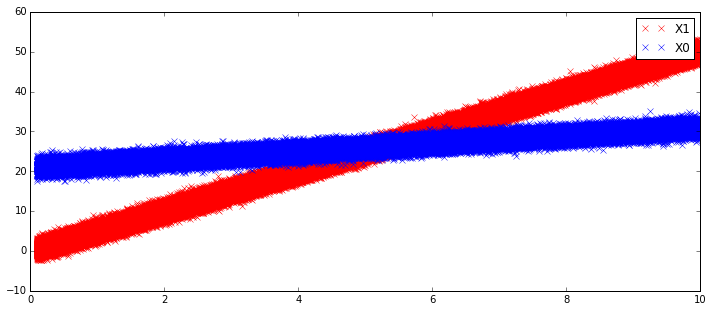

In [294]:
num_datapoints = 500000
num_arms = 2


def sigmoid(X):
    return 1./(1+np.exp(-X))

def evaluate2(X,logistic = False):
    if logistic == True:
        return np.round(sigmoid(X[0]*10 + X[1]* -50 + np.random.normal(0,5,np.atleast_2d(X).shape[0])))
    return 10*X[1]+ X[0]*5 + X[0]*X[1]*5 + 1-X[1] * -20


def evaluate(X,simple=True):
    simple =True
    if simple:
        return  X[0]*X[1]*5 +  (1-X[1])*X[0] + (1-X[1])*20 +np.random.normal(1-X[1],1)
    else:
        return  np.sin(X[0]*X[1]**2*1/2)*15 +  (1-X[1])*X[0] + (1-X[1]) +np.random.normal(1-X[1],1)
    

#def evaluate(X):
#    return stats.multivariate_normal.pdf(X,mean=None,cov=1)
    

X = np.array([np.linspace(.1,10,num_datapoints),np.random.binomial(num_arms-1,.7,num_datapoints)])
#X = np.array([np.random.binomial(10,.2,num_datapoints)*2,np.random.binomial(num_arms-1,.7,num_datapoints)])

y = []
for i in range(X.shape[1]):
    y += [evaluate(X[:,i])]

    
y = np.array(y)

if num_arms ==2: 
    plt.plot(X[0][X[1].astype(bool)],y[X[1].astype(bool)],'x',color='red',label = 'X1')
    plt.plot(X[0][~X[1].astype(bool)],y[~X[1].astype(bool)],'x',color='blue',label = 'X0')
    plt.legend()
    
else:
    plt.plot(X[0],y,'x')


# linear thompson

In [325]:
class linear_thompson(object):
    def __init__(self,arms = [0,1],mu = None,len_cont = 1,nu_sq = 150,f = 0):
        self.num_arms = len(arms)
        self.arms = arms
        if mu == None: #no prior
            self.mu = np.zeros(shape = (self.num_arms+len_cont))
        else: 
            self.mu = mu
        self.f = np.zeros(self.num_arms+len_cont)+f

        self.B = np.eye(self.num_arms+len_cont)
        self.Binv = np.linalg.inv(self.B)

        self.nu_sq = nu_sq
        
    def make_context(self,arm,context,from_):
        compl_cont = self.add_intercept(context+arm)
        #print( from_ + str(compl_cont[0]))
        return compl_cont[0]
        #return np.atleast_2d(arm+context)

        
    def add_intercept(self,X):
        try:
            X.shape[1]
        except:
            X = np.atleast_2d(X)
        X_new = np.ones((X.shape[0],X.shape[1]+1),dtype=X.dtype)
        X_new[:,1:] = X[:,:]
        return X_new
    
    

    
    def select_arm(self,context = []):
        """context is a list?"""
        samples = []
        
        L = np.linalg.cholesky(self.nu_sq**2*self.Binv)
        norm = np.random.normal(size=self.num_arms+1)
        #print('mu' + str(self.mu.shape))
        #print('L' + str(L.shape))
        #print('norm' + str(norm.shape))

        self.muc = self.mu + np.dot(L,norm)
        #print('muc' + str(self.muc.shape))
        
        for i in range(self.num_arms):
            complete_context = self.make_context(self.arms[i],context,'select')
            #print(complete_context.shape)
            
            samples += [np.dot(complete_context,self.muc)]
            #print(samples)
            
        self.muc = None
        #print('samples' + str(samples))
        return samples.index(max(samples))
        #return np.unravel_index(np.argmax(samples), self.n_arms)

    
    
    def update(self,reward,arm,context):
        complete_context = self.make_context(self.arms[arm],[context],'update')
        #print(self.arms[arm][0])
        #print(context)
        #print(complete_context)
        #print(self.B)
        #print(np.outer(complete_context,complete_context))
        self.B = self.B + np.outer(complete_context,complete_context)
        self.Binv = np.linalg.inv(self.B)
        #print(self.f,complete_context,reward)
        self.f = self.f + complete_context*reward
        self.f = self.f #what,why
        #print('f' + str(self.f.shape))
        self.mu =  np.dot(self.Binv,self.f)
        #print('')
        #print('mu' + str(self.mu.shape))

    
    
 
        

In [326]:
th = linear_thompson(arms = [[0],[1]])#,contexts=[X[:,0]])
th.mu

array([ 0.,  0.,  0.])

In [327]:
np.atleast_2d(X[0][0]).shape

(1, 1)

In [328]:
simple = False
shuffle = False

avg_regret_list = []
rand_regret_list =[]
for i in range(2):
    
    actual_reward_list = []
    optimal_reward_list = []
    random_reward_list = []
    arm_list = []
    
    index = list(range(X.shape[1]))
    if shuffle ==True:
                np.random.shuffle(index)
    for i in index:
    
    #for i in range(X.shape[1]):
        opt_arm = 1
        if X[0][i] < 5:
                opt_arm = 0
            

        context = X[0][i]
        random_arm = np.random.binomial(1,.5)
        random_reward = evaluate([context,random_arm],simple)
        random_reward_list += [random_reward]

        optimal_reward = evaluate([context,opt_arm],simple)#faulty! Should be optimal arm :-/
        optimal_reward_list += [optimal_reward]

        arm = th.select_arm([context])
        arm_list += [arm]

        actual_reward = evaluate([context,arm],simple)
        #print(actual_reward)
        actual_reward_list += [actual_reward]

        th.update(actual_reward,arm,context)

    random_reward_list = np.array(random_reward_list)    
    optimal_reward_list = np.array(optimal_reward_list)
    arm_list = np.array(arm_list)
    actual_reward_list = np.array(actual_reward_list)
    regret = (actual_reward_list - optimal_reward_list)
    avg_regret_list += [np.mean(regret)]
    random_regret = (random_reward_list - optimal_reward_list)
    rand_regret_list += [np.mean(random_regret)]



In [329]:
actual_reward_list[:10]

array([ 2.76411248,  2.56900913,  1.29022937,  1.96791275, -0.79289898,
        1.44988838, -0.673513  ,  0.63005761,  1.02091227,  0.35656623])

In [330]:
optimal_reward_list[:10]

array([ 20.69834843,  19.30182824,  20.9396102 ,  20.5591825 ,
        22.45628999,  22.3113392 ,  20.78551589,  20.8488132 ,
        19.94480815,  21.64461704])

In [331]:
random_reward_list[:10]

array([  0.58928238,   0.50247403,   0.65051959,  21.06093264,
        21.00391563,  -0.0733054 ,  21.93526829,  20.52496091,
         1.29754674,  20.0287931 ])

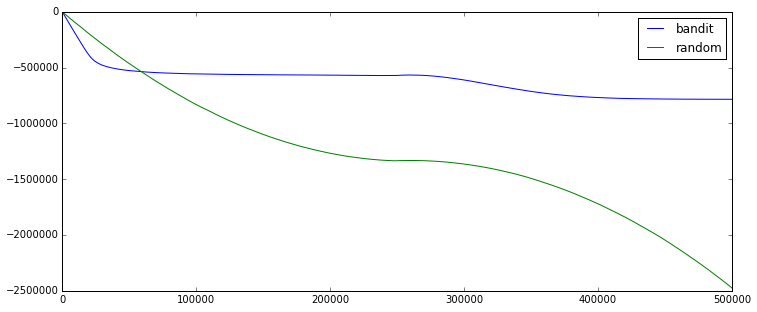

In [332]:
plt.plot(np.cumsum(regret),label='bandit')
plt.plot(np.cumsum(random_regret),label = 'random')

leg = plt.legend()

In [333]:
np.mean(arm_list)

0.42958600000000002

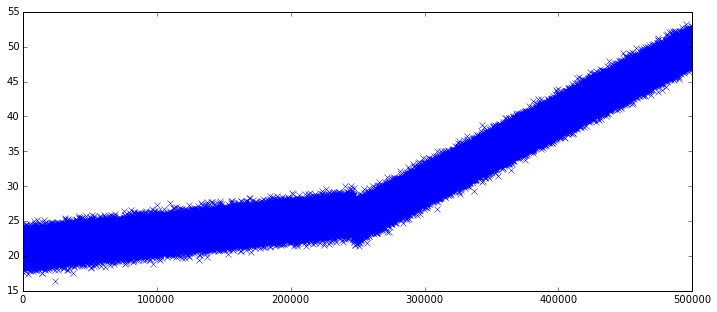

In [334]:
plt.plot(optimal_reward_list,'x')

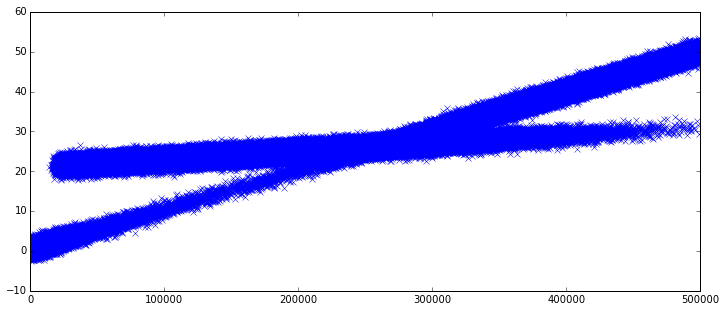

In [335]:
plt.plot(actual_reward_list,'x')